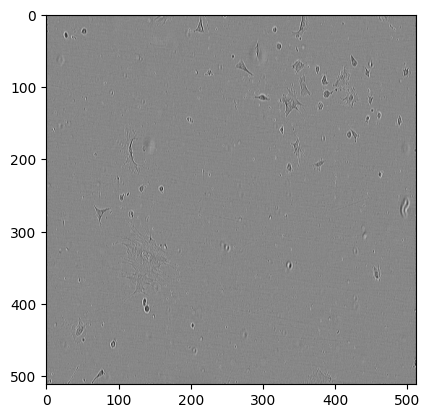

In [2]:
import numpy as np
import matplotlib.pyplot as plt

img = np.load("cleaned.npy")
plt.imshow(img, cmap='gray')


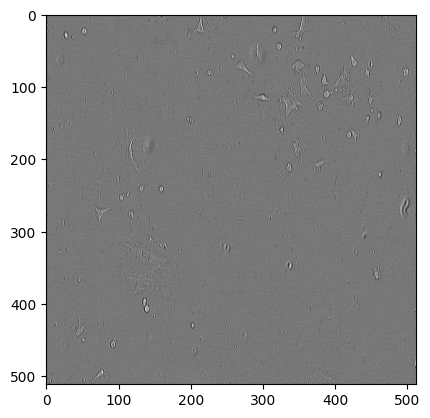

In [3]:
# invert it so that th backgrohndis darker 

from skimage.util import invert
img = invert(img)
plt.imshow(img, cmap='gray')

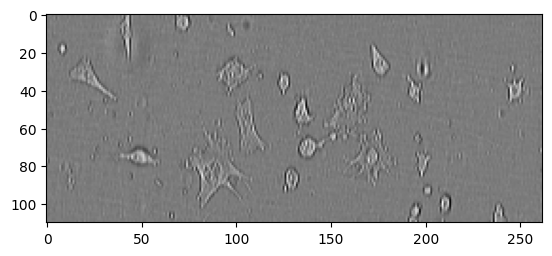

In [4]:
sub = img[40:150, 250:]
plt.imshow(sub, cmap='gray')

I use the ideas of what we discussed this morning to construct a linear conbinations of filters that is in some sense optimal. Here I reconstruct their ability to reproduce the original image.

In a way, via deconstructing and reconstructing the image, we throw away the stuff that is not important (because it gets cancelled by the filters) and keep the importnat features (the cells)

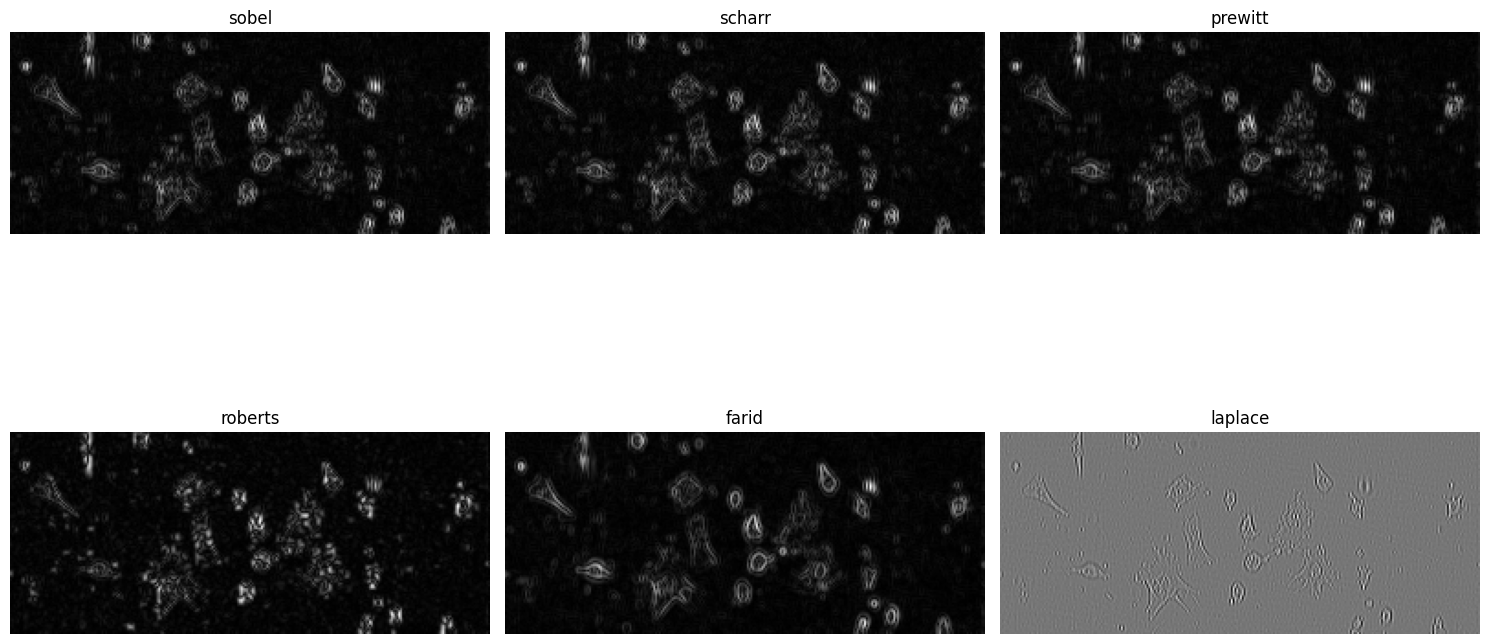

In [5]:
from skimage.filters import sobel, scharr, prewitt, roberts, farid, laplace

def apply_filter(image, edge_filter):
    """
    Apply an edge filter to the image and normalize the output to [0, 1].

    Parameters:
        image (np.ndarray): Input image.
        edge_filter (callable): Edge filter function (e.g., skimage.filters.sobel).

    Returns:
        np.ndarray: Normalized edge-filtered image.
    """
    filtered = edge_filter(image)
    min_val = filtered.min()
    max_val = filtered.max()
    if max_val > min_val:
        normalized = (filtered - min_val) / (max_val - min_val)
    else:
        normalized = np.zeros_like(filtered)
    return normalized

edge_filters = [sobel, scharr, prewitt, roberts, farid, laplace]


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, edge_filter in enumerate(edge_filters):
    filtered_img = apply_filter(sub, edge_filter)
    axes[idx].imshow(filtered_img, cmap='gray')
    axes[idx].set_title(edge_filter.__name__)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

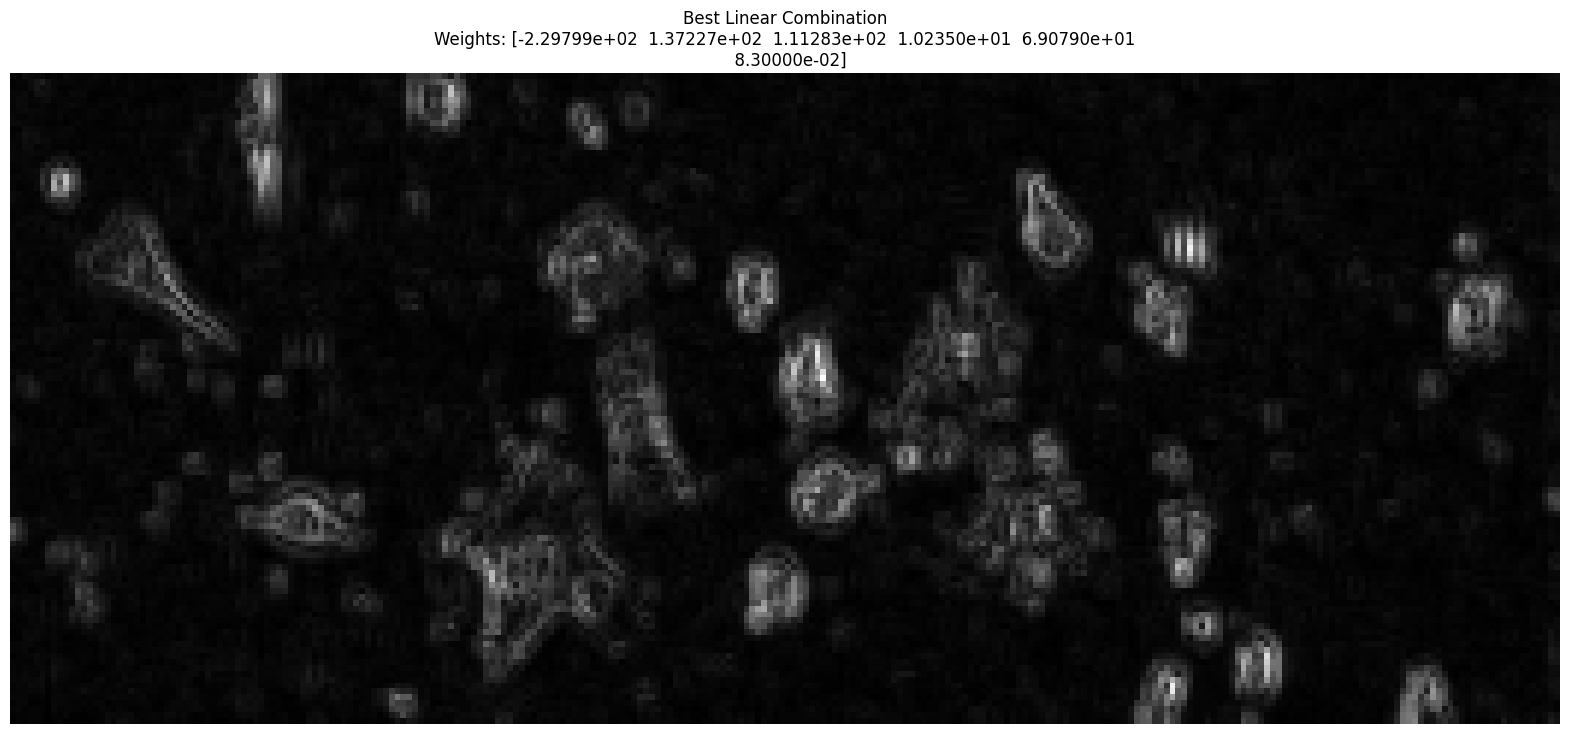

In [6]:
from sklearn.linear_model import LinearRegression

def best_linear_combination(sub, edge_filters, target=None):
    """
    Find the best linear combination of edge filters to approximate a target image (or sub itself if target is None).
    Returns the weights and the combined image.
    """
    # Apply all edge filters to sub
    filtered_imgs = [f(sub).ravel() for f in edge_filters]
    X = np.stack(filtered_imgs, axis=1)
    if target is None:
        # Use sub as the target (flattened)
        y = sub.ravel()
    else:
        y = target.ravel()
    # Fit linear regression
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    weights = reg.coef_
    combined = np.sum([w * f(sub) for w, f in zip(weights, edge_filters)], axis=0)
    return weights, combined

# Example usage:
weights, combined_img = best_linear_combination(sub, edge_filters)
plt.figure(figsize=(20, 10))
plt.imshow(combined_img, cmap='gray')
plt.title(f'Best Linear Combination\nWeights: {np.round(weights, 3)}')
plt.axis('off')
plt.show()

Indeed the image above looks nice, with a rather uniform background. It seems to make sense.

## Contrs reconstruction

I tried a few startegies to the isolate the cells, and it seems that sinc ethy are so irregular, a good way to proceed is to use the contours of the cells. I use the `find_contours` function from `skimage.measure` to find the contours of the cells in the image.

For that to work however, I crucially ned a threshold. At the moment I use the 85th percentile of the pixel values in the image, but I am not sure if that is the best way to do it. It would probably not work very well when we have more cells.

Maybe if we find a distinctve absolute value we can use it at some point across the entire video.

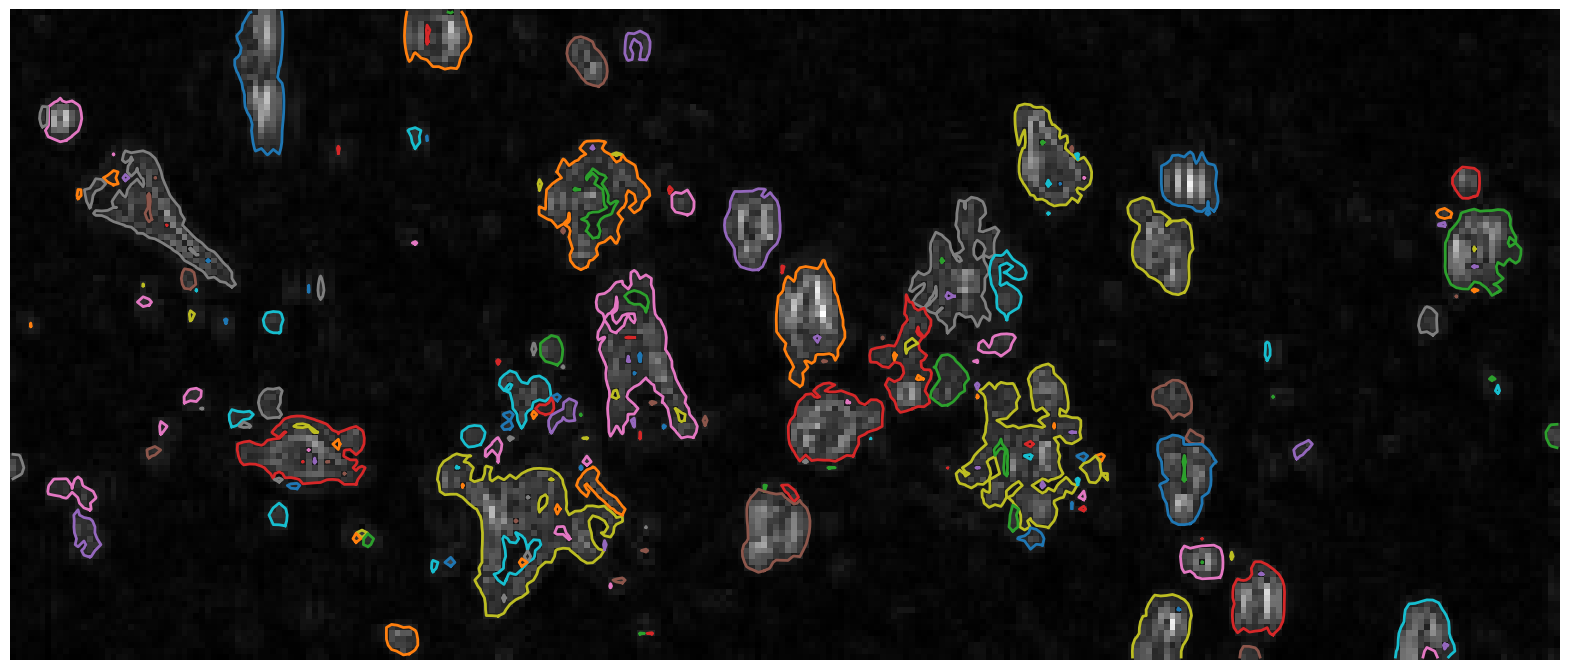

In [7]:
from skimage.measure import find_contours
threshold  = np.percentile(combined_img, 87)  # Adjust threshold as needed
contours = find_contours(combined_img, threshold)
plt.figure(figsize=(20, 10))
plt.imshow(combined_img, cmap='gray')
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.axis('off')
plt.show()

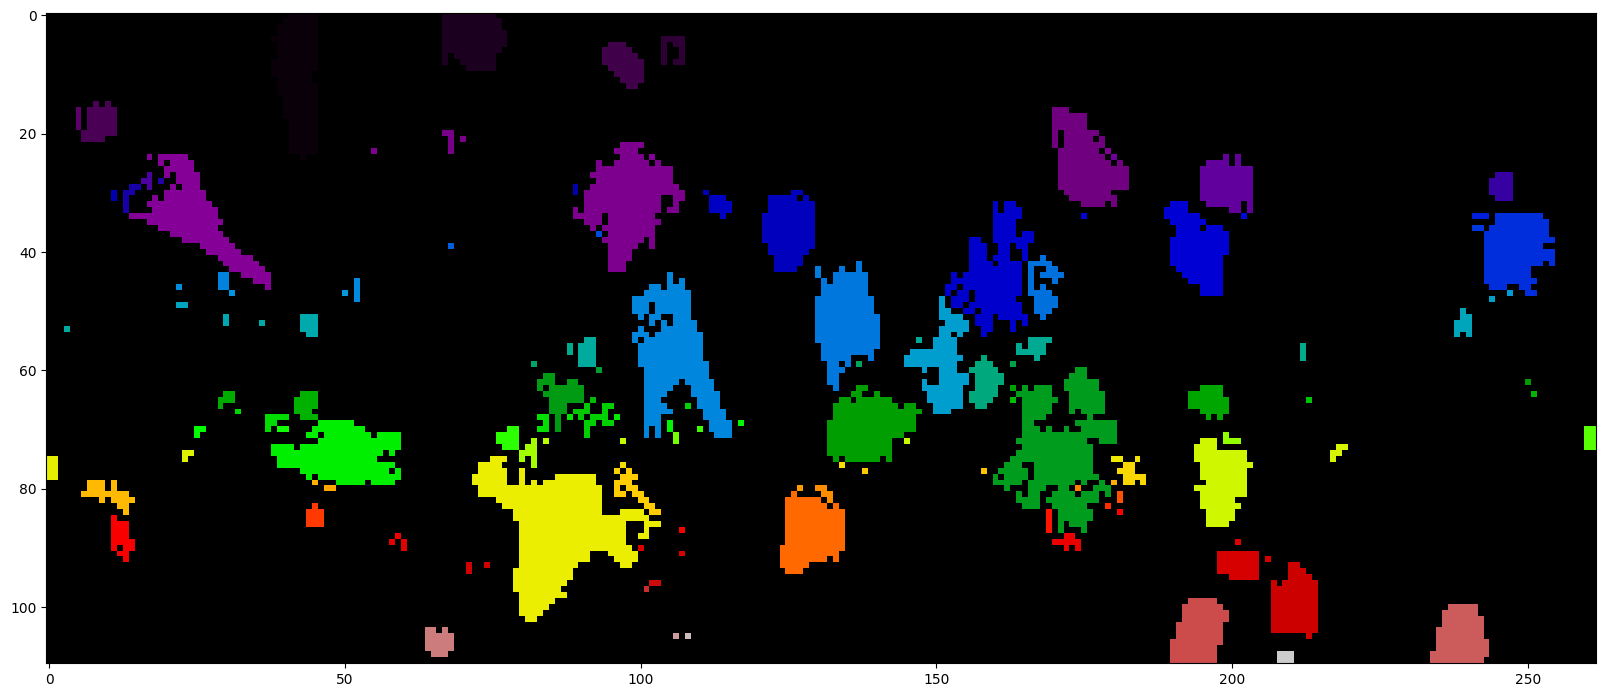

In [8]:
import numpy as np
from skimage.draw import polygon

segmentation_mask = np.zeros(combined_img.shape, dtype=np.uint16)
current_label = 1

for contour in contours:
    rr, cc = polygon(contour[:, 0], contour[:, 1], shape=combined_img.shape)
    # Check if majority of polygon pixels already labeled
    existing_labels = segmentation_mask[rr, cc]
    unique_labels = np.unique(existing_labels[existing_labels > 0])
    if len(unique_labels) == 1:
        # Assign existing label
        label_to_use = unique_labels[0]
    else:
        # Assign new label
        label_to_use = current_label
        current_label += 1
    segmentation_mask[rr, cc] = label_to_use
plt.figure(figsize=(20, 10))    
plt.imshow(segmentation_mask, cmap='nipy_spectral')

(np.float64(-0.5), np.float64(261.5), np.float64(109.5), np.float64(-0.5))

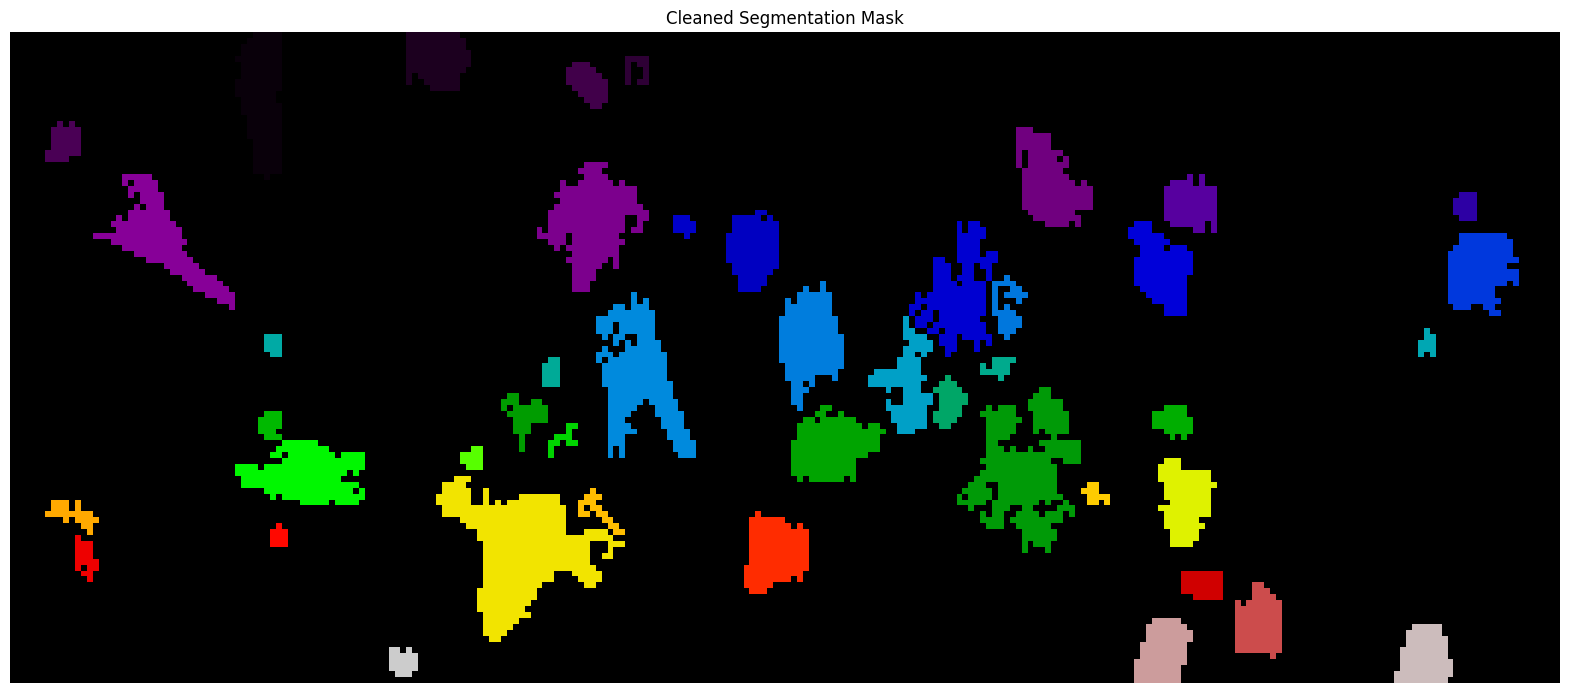

In [9]:
from skimage.morphology import remove_small_objects

# Remove small objects from segmentation_mask
min_area = 10  # You can adjust this threshold as needed
cleaned_labelled = remove_small_objects(segmentation_mask, min_size=min_area)

plt.figure(figsize=(20, 10))
plt.imshow(cleaned_labelled, cmap='nipy_spectral')
plt.title('Cleaned Segmentation Mask')
plt.axis('off')

## Alternative : pretrained models

`cellpose` provides pretrained models that can be used directly for segmentation tasks. These models are trained on various datasets and can be used without the need for additional training.

You can install it using pip:

```bash
pip install cellpose
```

It seems it picks too much roundness, but we could maybe combine the two ideaas, or start labelling teh imnages with the method above and retrain cellpose.

In [ ]:
pip uninstall cellpose

In [10]:
# Create model (CPU will be used automatically)
from cellpose import models
import torch

device = torch.device("mps") 


In [11]:
import cellpose
cellpose.version_str

'\ncellpose version: \t3.0.9 \nplatform:       \tdarwin \npython version: \t3.12.11 \ntorch version:  \t2.7.1'

In [14]:
# Original version
from skimage.filters import sobel, scharr
model = models.CellposeModel(model_type='cyto2',
                         device=device

                         )


In [17]:
help( model.eval)

Help on method eval in module cellpose.models:

eval(x, batch_size=8, resample=True, channels=None, channel_axis=None, z_axis=None, normalize=True, invert=False, rescale=None, diameter=None, flow_threshold=0.4, cellprob_threshold=0.0, do_3D=False, anisotropy=None, stitch_threshold=0.0, min_size=15, niter=None, augment=False, tile=True, tile_overlap=0.1, bsize=224, interp=True, compute_masks=True, progress=None) method of cellpose.models.CellposeModel instance
    segment list of images x, or 4D array - Z x nchan x Y x X

    Args:
        x (list, np.ndarry): can be list of 2D/3D/4D images, or array of 2D/3D/4D images
        batch_size (int, optional): number of 224x224 patches to run simultaneously on the GPU
            (can make smaller or bigger depending on GPU memory usage). Defaults to 8.
        resample (bool, optional): run dynamics at original image size (will be slower but create more accurate boundaries). Defaults to True.
        channels (list, optional): list of channe

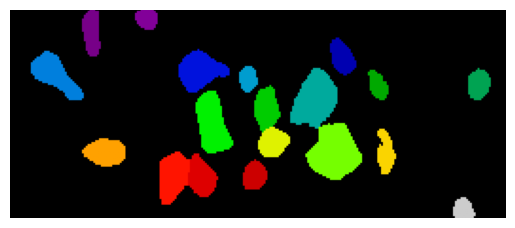

In [18]:

# Run segmentation (single grayscale channel)
masks, flows, styles = model.eval(
    [scharr(sub)],
    diameter=None,


)

# Display masks
plt.imshow(masks[0], cmap='nipy_spectral')
plt.axis('off')
plt.show()

labelled = masks[0]

## Refinement using random walk

I get three classes:

- confident background
- confident cells
- uncertain foreground

[(np.float64(11.81578947368421), np.float64(42.66315789473684)), (np.float64(4.724770642201835), np.float64(71.81651376146789)), (np.float64(24.91304347826087), np.float64(175.0163043478261)), (np.float64(32.0132625994695), np.float64(99.95755968169762)), (np.float64(34.407407407407405), np.float64(23.45014245014245)), (np.float64(36.32710280373832), np.float64(125.34579439252336)), (np.float64(47.299065420560744), np.float64(160.55514018691588)), (np.float64(39.210191082802545), np.float64(247.1656050955414)), (np.float64(39.771186440677965), np.float64(193.96610169491527)), (np.float64(51.865546218487395), np.float64(135.03781512605042)), (np.float64(59.97701149425287), np.float64(106.39310344827587)), (np.float64(75.00492610837438), np.float64(170.8768472906404)), (np.float64(69.82587064676616), np.float64(138.53233830845772)), (np.float64(75.03658536585365), np.float64(197.9329268292683)), (np.float64(74.97674418604652), np.float64(49.94961240310077)), (np.float64(87.81818181818181

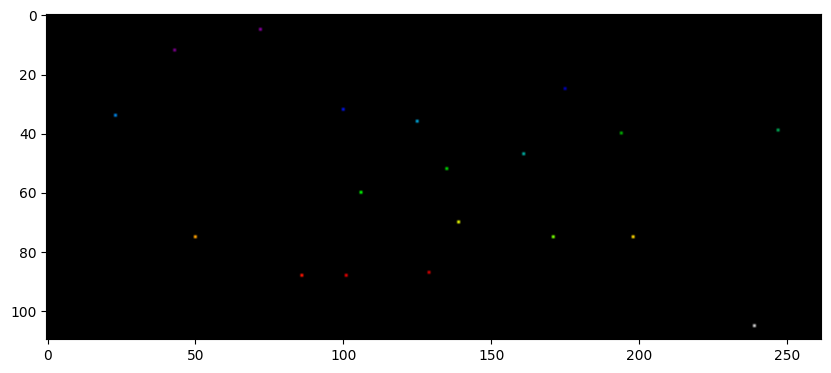

In [19]:
from skimage.measure import regionprops, label

regions = regionprops(labelled)
centres = [region.centroid for region in regions]
print(centres)

centres_img = np.zeros_like(labelled)
for i, (y, x) in enumerate(centres, 1):
    cy, cx = int(round(y)), int(round(x))
    if 0 <= cy < centres_img.shape[0] and 0 <= cx < centres_img.shape[1]:
        centres_img[cy, cx] = i

plt.figure(figsize=(10, 10))
plt.imshow(centres_img, cmap='nipy_spectral')


In [20]:
from skimage.segmentation import random_walker
confident_bkg = dilated == 0
confident_cell = centres_img > 0
markers = np.zeros_like(masks[0])
markers[confident_bkg] = 1
markers[confident_cell] = centres_img [confident_cell]
from skimage.util import invert

sub_inverted = invert(sub)
pb = random_walker(sub_inverted, markers, beta=1000, mode='bf',return_full_prob=True)
plt.figure(figsize=(20, 10))
plt.imshow(markers, cmap='nipy_spectral')
plt.figure( figsize=(20, 10))
plt.imshow(sub_inverted)

NameError: name 'dilated' is not defined

In [ ]:

plt.figure(figsize=(20, 10))
plt.imshow(pb[1], cmap='gray')
plt.colorbar()